# TP2 Visión por Computadora 1 CEIA FIUBA
Profesor: Ing. Maxim Dorogov
Autores:
        Alvarez, Jorge Adrián
        Peñaranda Peralta, Daniel Eduardo

**Objetivo:**
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Extracción de los cuadros del video `focus_video.mov` a un array de imágenes

Cuadros cargados: 171 - arreglo con forma (171, 360, 640)


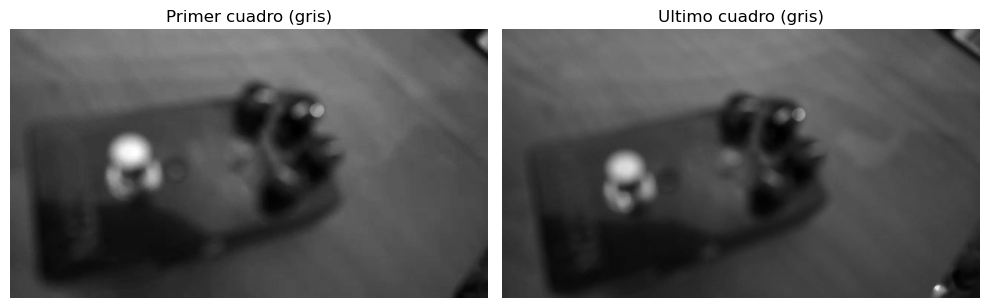

In [4]:
video_path = "focus_video.mov"
cap = cv2.VideoCapture(video_path)
frames_gray = []
if not cap.isOpened():
    raise IOError(f"No se pudo abrir el video en {video_path}")

while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames_gray.append(gray)

cap.release()

frames_gray = np.array(frames_gray)
num_frames = frames_gray.shape[0]
print(f"Cuadros cargados: {num_frames} - arreglo con forma {frames_gray.shape}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(frames_gray[0], cmap="gray")
axes[0].set_title("Primer cuadro (gris)")
axes[0].axis("off")

axes[1].imshow(frames_gray[-1], cmap="gray")
axes[1].set_title("Ultimo cuadro (gris)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

# 1. Medida de desenfoque en el dominio de la frecuencia
Clase calidad de enfoque con métodos:
- `_fm_fram` realiza en el cálculo de `coeficiente calidad de enfoque` (FM Image Quality measure, en el trabajo) para una imagen de $ N \times M $, según del algoritmo propuesto por Kanjar De and V. Masilamani en el trabajo *Image Sharpness Measure for Blurred Images in Frequency Domain*   
- `calidad` recibe un array de $ r $ ROIs tomados de $ t $  de tamaño $ N \times M $: $(r,t,N,M)$. También acepta arrays de $t$ cuadros de tamaño $ N \times M $: $(t,N,M)$ y devuelve un array de $r$ filas con $t$ `coeficientes de calidad de enfoque`: $(r,t)$ en el primer caso y $t$ `coeficientes de calidad de enfoque` ($t$,) en el segundo caso. La variable booleana *unsharp_it* permite elegir si se aplica sharp_mask a cada cuadro antes de calcular el FM. 
- `grafico` devuelve el `coeficiente de calidad de enfoque` **máximo** y el cuadro en el que se alcanza y el gráfico de los coeficientes por cuadro. 

In [5]:
class CalidadEnfoque:
    """Calcula FM cuadro a cuadro y grafica los resultados."""

    def __init__(self, threshold: float = 1000.0):
        self.threshold = threshold

    @staticmethod
    def unsharp_mask(image:np.ndarray, blur_ksize:int = 5, amount:float = 1.5) -> np.ndarray:
        blurred = cv2.GaussianBlur(image, (blur_ksize, blur_ksize), 0)
        sharpened = cv2.addWeighted(image, 1 + amount, blurred, -amount, 0)
        return sharpened
        
    def _fm_frame(self, image: np.ndarray, unsharp_it:bool = False) -> float:
        
        if unsharp_it:
            image = self.unsharp_mask(image)
            
        float_img = np.float32(image)
        fourier = cv2.dft(float_img, flags=cv2.DFT_COMPLEX_OUTPUT)
        fourier_centered = np.fft.fftshift(fourier)
        magnitude = cv2.magnitude(fourier_centered[:, :, 0], fourier_centered[:, :, 1])
        max_val = magnitude.max()
        if max_val == 0:
            return 0.0

        threshold = max_val / self.threshold
        th = np.count_nonzero(magnitude > threshold)
        rows, cols = image.shape
        fm = th / (rows * cols)
        return fm

    def calidad(self, frames: np.ndarray, unsharp_it:bool = False) -> np.ndarray:
        """Devuelve el FM para cada cuadro (o filas de cuadros)."""
        arr = np.array(frames)
        if arr.ndim == 3:
            sequences = arr[None, ...]
            squeeze_output = True
        elif arr.ndim == 4:
            sequences = arr
            squeeze_output = False
        else:
            raise ValueError(
                "Esperaba un array de forma (cuadros, alto, ancho) o (filas, cuadros, alto, ancho)."
            )

        fm_rows = []
        for seq in sequences:
            fm_seq = np.array([self._fm_frame(frame, unsharp_it) for frame in seq])
            fm_rows.append(fm_seq)

        fm_array = np.stack(fm_rows, axis=0)
        return fm_array[0] if squeeze_output else np.mean(fm_array,axis=0)#Se promedian los coeficientes obtenidos para cada ROI

    def grafico(self, fm_values: np.ndarray):
        """Grafica FM vs. numero de cuadro y devuelve maximos y posiciones."""
        fm_arr = np.array(fm_values, dtype=float)
        if fm_arr.ndim == 1:
            fm_arr = fm_arr[None, :]
            squeeze_output = True
        elif fm_arr.ndim == 2: #Al tomar promedio del los ROI no se obtendrán fm_arr de dimensión 2 
            squeeze_output = False
        else:
            raise ValueError("Esperaba un array 1D (cuadros) o 2D (filas, cuadros) con medidas de enfoque.")

        plt.figure(figsize=(10, 6))
        maxima = []
        frame_idx = np.arange(fm_arr.shape[1])

        for idx, row in enumerate(fm_arr):
            plt.scatter(frame_idx, row)
            max_pos = int(np.argmax(row))
            max_val = float(row[max_pos])
            maxima.append([max_val, max_pos])

        plt.xlabel("Numero de cuadro")
        plt.ylabel("Medida de enfoque (FM)")
        plt.title("Calidad de enfoque por cuadro")
       
        if fm_arr.shape[0] > 1:
            plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if squeeze_output:
            output=maxima[0]
            plt.plot(output[1], output[0], 'ro')
        else:
            m=np.asarray(maxima)
            idx=np.argmax(m[:,0])
            output=[int(idx+1)]+maxima[idx] 
            plt.plot(output[2], output[1], 'ro')
        plt.show()
        return output


Se calcula el índice de enfoque máximo sobre el total de la imagen en cada cuadro y se muestra cual es el cuadro para que este índice es máximo

Forma del array FM: (171,)


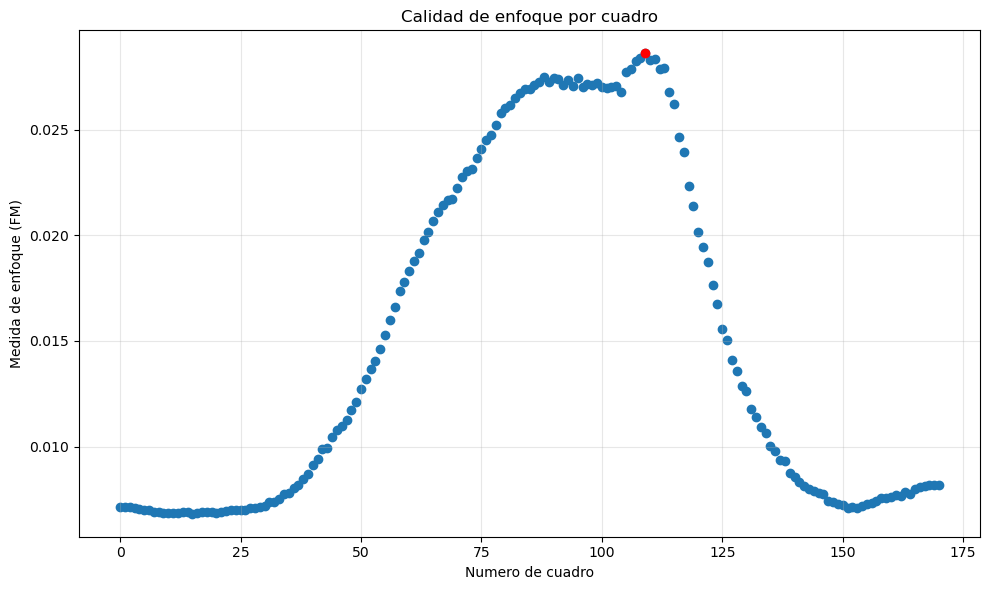

Máximo y cuadro correspondiente: [0.028624131944444443, 109]


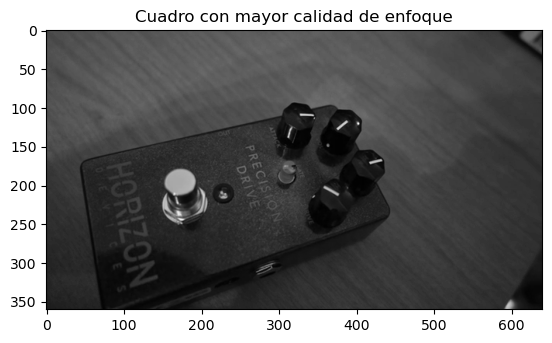

In [6]:

analyzer = CalidadEnfoque()
fm_por_cuadro = analyzer.calidad(frames_gray)
print(f"Forma del array FM: {fm_por_cuadro.shape}")

maximo = analyzer.grafico(fm_por_cuadro)
print("Máximo y cuadro correspondiente:", maximo)
plt.imshow(frames_gray[maximo[1]], cmap="gray")
plt.title("Cuadro con mayor calidad de enfoque")
plt.show()

Se define la función `extraer_reticula_central` que toma un cuadro y devuelve el recorte de una region central (ROI central) de un dado porcentaje de la imagen. Devuelve además las coordenadas de la ROI central.  

In [8]:
def extraer_reticula_central(frames: np.ndarray, porcentaje: float = 0.07):
    """Extrae una reticula central de cada cuadro.

    Devuelve las coordenadas (x1, y1, x2, y2) y el array de recortes.
    """
    arr = np.array(frames)
    if arr.ndim != 3:
        raise ValueError("Esperaba un array de forma (cuadros, alto, ancho) en escala de grises.")

    h, w = arr.shape[1:]
    ancho = max(1, int(w * porcentaje))
    alto = max(1, int(h * porcentaje))
    x1 = (w - ancho) // 2
    y1 = (h - alto) // 2
    x2 = x1 + ancho
    y2 = y1 + alto

    recortes = arr[:, y1:y2, x1:x2]
    return (x1, y1, x2, y2), recortes


Se visualiza un cuadro y el correspondiente recorte central.

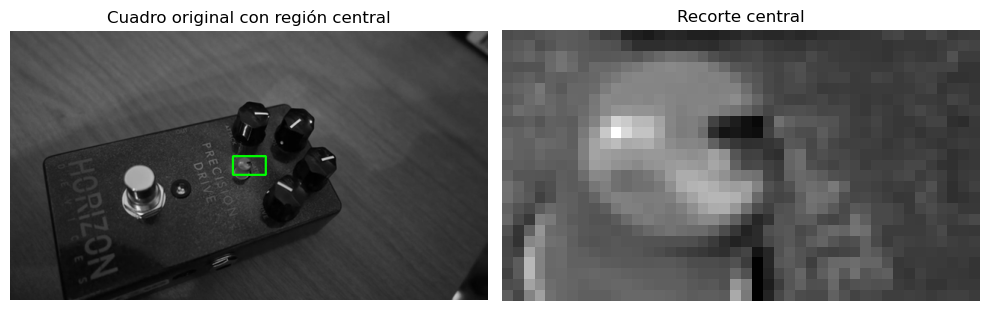

In [9]:
# Recorte central y visualización, Ejemplo.
coords, recortes = extraer_reticula_central(frames_gray)
x1, y1, x2, y2 = coords
frame_idx =109

frame_bgr = cv2.cvtColor(frames_gray[frame_idx], cv2.COLOR_GRAY2BGR)
cv2.rectangle(frame_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB))
axes[0].set_title("Cuadro original con región central")
axes[0].axis("off")

axes[1].imshow(recortes[frame_idx], cmap="gray")
axes[1].set_title("Recorte central")
axes[1].axis("off")

plt.tight_layout()
plt.show()



Se calcula la calidad de enfoque sobre los recortes obtenidos de cada cuadro, se grafica por cuadro.
Se muestra el cuadro donde el `coeficiente de calidad de enfoque` fue máximo.

Forma del array FM (reticula): (171,)


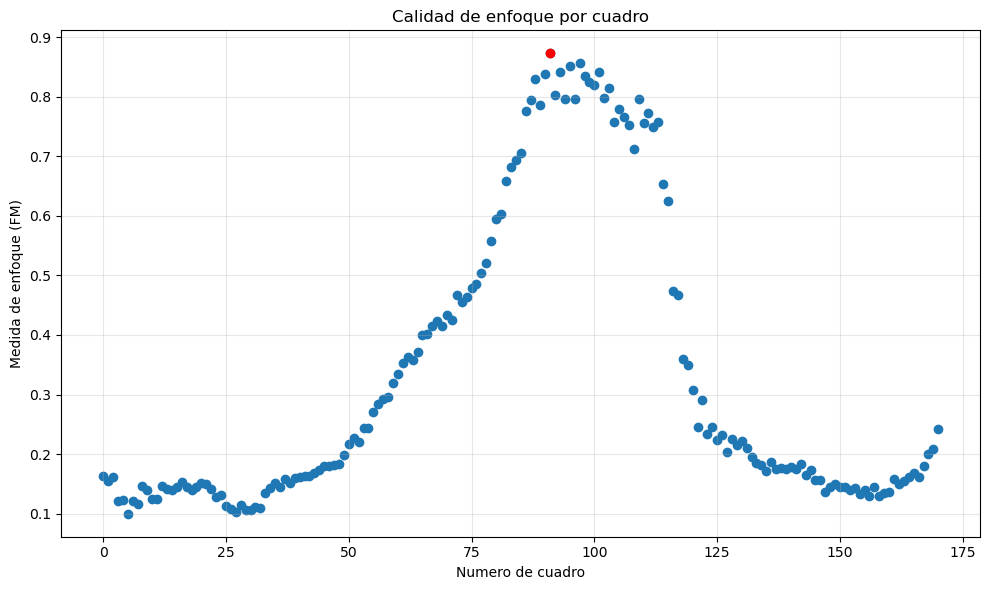

Maximo y cuadro (reticula): [0.8727272727272727, 91]


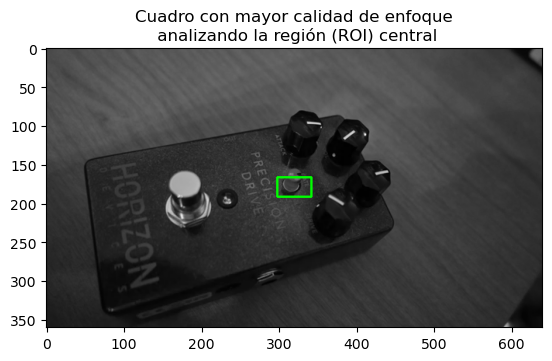

In [12]:
# Calidad de enfoque sobre la reticula extraida
analyzer_recorte = CalidadEnfoque()
fm_reticula = analyzer_recorte.calidad(recortes)
print(f"Forma del array FM (reticula): {fm_reticula.shape}")
maximo_reticula = analyzer_recorte.grafico(fm_reticula)
print("Maximo y cuadro (reticula):", maximo_reticula)

frame_bgr = cv2.cvtColor(frames_gray[maximo_reticula[1]], cv2.COLOR_GRAY2BGR)
cv2.rectangle(frame_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(frame_bgr , cmap="gray")
plt.title("Cuadro con mayor calidad de enfoque\n analizando la región (ROI) central")
plt.show()

Se observa que el mismo algoritmo de calidad de enfoque aplicado sobre una region específica encuentra una mayor calidad de enfoque 18 cuadros antes que analizando la imagen completa. Entre estos dos extremos -una pequeña porción central de la imagen (se considera en el entorno del eje óptico del sistema) y toda imagen- se analiza seguidamente el análisis sobre una matriz de enfoque.   

In [11]:
def calculo_matriz_enfoque(h: int, w: int, rows: int=4, cols:int=6, porcentaje: float=0.5):
    """
    Calcula las coordenadas (x0, y0, x1, y1) de una grilla de retículas
    centrada en la imagen, equiespaciadas.
    Devuelve:
      - boxes: lista de tuplas (x0, y0, x1, y1)
      - patch_size: lado (en píxeles) de cada retícula
      - coverage: fracción de área de imagen cubierta por las retículas
    """
    # rectángulo proporcional a la imagen donde se ubica la matriz de enfoque
    ancho = max(1, int(w * porcentaje))
    alto = max(1, int(h * porcentaje))
    x1 = (w - ancho) // 2 # coordenada de inicio para centrar la matriz
    y1 = (h - alto) // 2
    x2 = x1 + ancho
    y2 = y1 + alto

    # lado de la retícula cuadrada: para que quepan (2*cols - 1) bloques horizontales
    # toma el menor de los lados
    # cuadrado, espacio, cuadrado, espacio, ... (cols cuadrados + cols-1 espacios)
    lado = int(
        min(
            (ancho) / (2 * cols - 1),
            (alto)/ (2 * rows - 1),
        )
    )
    boxes = []
    for r in range(rows):
        for c in range(cols):
            x0 = x1 + (2 * c) * lado
            y0 = y1 + (2 * r) * lado
            x_1 = x0 + lado
            y_1 = y0 + lado
            boxes.append((x0, y0, x_1, y_1))

    # porcentaje de área cubierta
    coverage = (len(boxes) * lado * lado) / (h * w)

    return boxes, lado, coverage

Se visualiza la Matriz sobre un cuadro del video.

In [13]:
def dibuja_matriz_sobre_frame(frame: np.array, boxes: list, color: tuple=(0, 255, 0), thickness: int=2)-> np.array:
    """
    Dibuja rectángulos en verde sobre una copia de 'frame'.
    """
    img_vis = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    
    for idx, (x0, y0, x1, y1) in enumerate(boxes):
        cv2.rectangle(img_vis, (x0, y0), (x1, y1), color, thickness)
        cv2.putText(img_vis,f'{idx+1}', (x0,y0-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
        
    return img_vis

<function matplotlib.pyplot.show(close=None, block=None)>

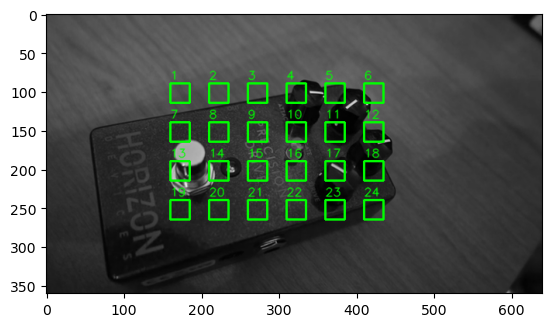

In [14]:
h, w = frames_gray.shape[1:]
boxes, lado, cobertura=calculo_matriz_enfoque(h,w) 
img=dibuja_matriz_sobre_frame(frames_gray[100],boxes)
plt.imshow(img)
plt.show


Se extraen las regiones de cada cuadro para el análisis de enfoque.

In [15]:
def extraer_regiones_de_frames(frames:np.array, rows:int=3, cols:int=6):
    """
    frames: np.ndarray de forma (t, H, W)
    Devuelve:
      - regiones: np.ndarray de forma (nro_roi= rows x cols, t, rh, rw),
      - boxes: lista de (x0, y0, x1, y1) compartida por todos los frames
      -lado,coverage: como en compute_reticles_grid
    """
    frames = np.asarray(frames)
    fr, h, w = frames.shape

    boxes,lado,coverage = calculo_matriz_enfoque(h, w, rows, cols)
    num_patches = len(boxes)

    num_boxes = len(boxes)
    regiones = [[] for _ in range(num_boxes)]   # una lista por cada retícula

    for t in range(fr):
        img = frames[t]
        for i, (x0, y0, x1, y1) in enumerate(boxes):
            roi = img[y0:y1, x0:x1].copy()
            regiones[i].append(roi)

    regiones = np.array(regiones)  # (nro_roi, fr, rh, rw)
    return regiones, boxes,lado,coverage

Se calcula en FM para cada ROI se promedia el resultado de todas las ROI en cada cuadro y se grafica el FM promedio por cada cuadro. 

Forma del array FM: (171,)


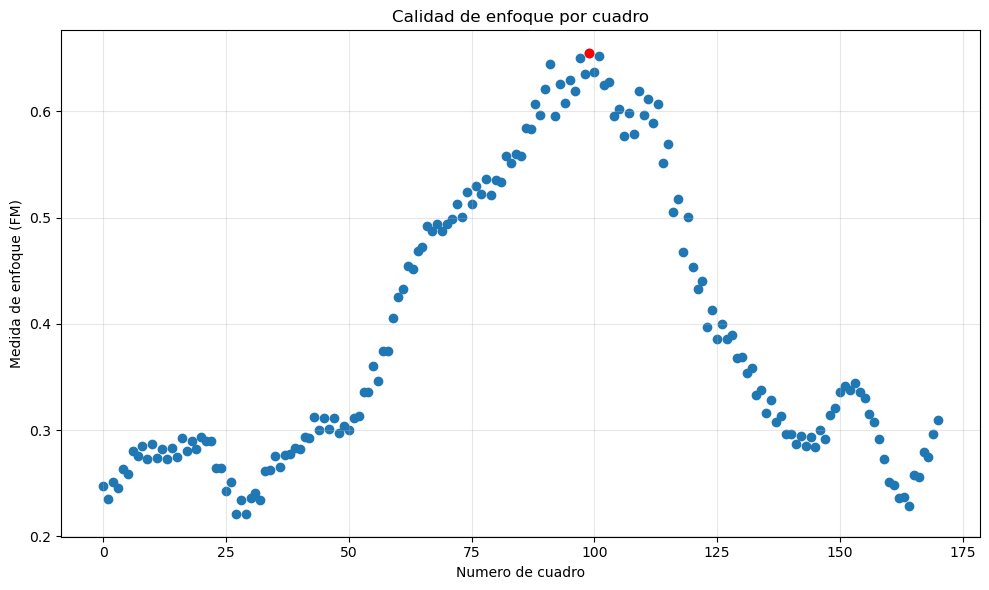

Máximo coeficiente de enfoque promedio:0.6545118245474963 y cuadro correspondiente: 99


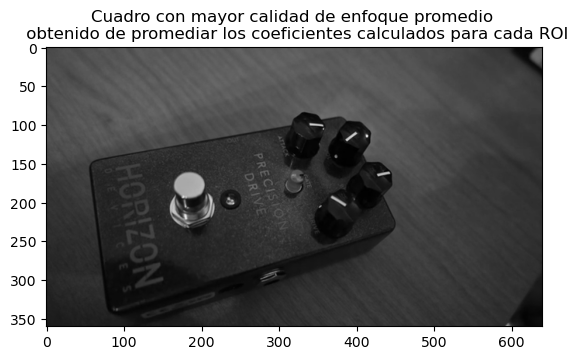

In [16]:
regiones, boxes,lado,coverage=extraer_regiones_de_frames(frames_gray)

analyzer = CalidadEnfoque()
fm_por_cuadro = analyzer.calidad(regiones)
print(f"Forma del array FM: {fm_por_cuadro.shape}")

maximo = analyzer.grafico(fm_por_cuadro)
print(f'Máximo coeficiente de enfoque promedio:{maximo[0]} y cuadro correspondiente: {maximo[1]}')

img_vis = cv2.cvtColor(frames_gray[maximo[1],...], cv2.COLOR_GRAY2BGR)
plt.imshow(img_vis)
plt.title('Cuadro con mayor calidad de enfoque promedio \n obtenido de promediar los coeficientes calculados para cada ROI')
plt.show()

Se encuentra el coeficiente de calidad de enfoque en un cuatro del video intermedio a los extremos mencionados anteriormente.

Forma del array FM: (171,)


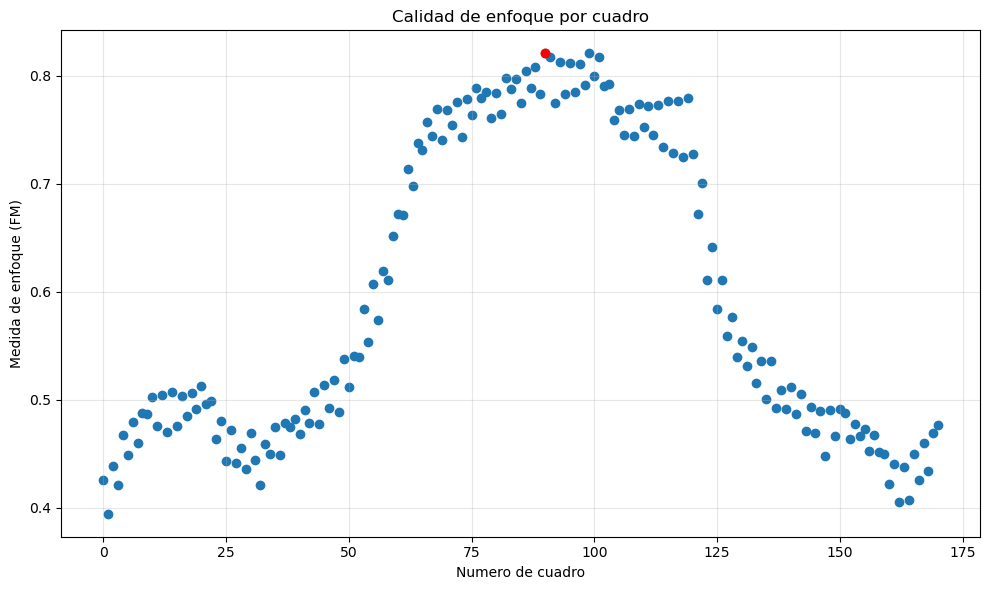

Máximo coeficiente de enfoque promedio:0.8205839608931166 y cuadro correspondiente: 90


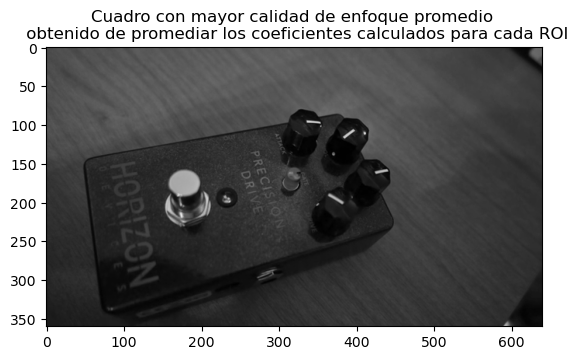

In [17]:

regiones, boxes,lado,coverage=extraer_regiones_de_frames(frames_gray)

analyzer = CalidadEnfoque()
fm_por_cuadro = analyzer.calidad(regiones, True)
print(f"Forma del array FM: {fm_por_cuadro.shape}")

maximo = analyzer.grafico(fm_por_cuadro)
print(f'Máximo coeficiente de enfoque promedio:{maximo[0]} y cuadro correspondiente: {maximo[1]}')

img_vis = cv2.cvtColor(frames_gray[maximo[1],...], cv2.COLOR_GRAY2BGR)
plt.imshow(img_vis)
plt.title('Cuadro con mayor calidad de enfoque promedio \n obtenido de promediar los coeficientes calculados para cada ROI')
plt.show()

La aplicación de unsharp mask eleva los valores de la métrica en todos los cuadros; sin embargo, el pico de enfoque que antes era bien definido ahora aparece como una meseta. Esto podría indicar que, al realzar por igual los detalles en todos los cuadros, la métrica FM alcanza su límite de sensibilidad y deja de discriminar con precisión el punto de mejor enfoque.    

Se realiza el mismo análisis anterior pero ahora aplicando `unsharp mask` a cada cuadro del video antes de extraer lo ROI

## 2. Utilización de la como factor de calidad de enfoque **Variance of Laplacian**

Del paper: Said P. et al., *Analysis of focus measure operators in shapefrom focus*

Pertenece a la familia Laplaciana (LAP4).

Los operadores Laplacianos fueron de los mejores en condiciones normales y bastante consistentes.

La varianza de la respuesta Laplaciana mide cuánto “cambia” la segunda derivada → escenas enfocadas tienen muchos bordes/detalles → alta varianza; escenas desenfocadas → Laplaciano más suave → baja varianza.

Es barato computacionalmente y se implementa directo con cv2.Laplacian + np.var. (no se normaliza pero var divide por n)

Se crea una clase que hereda de la anterior y redefine el método `_fm_frame` para aplicar *enfoque laplaciano*.

In [19]:
class CalidadEnfoqueLaplaciano(CalidadEnfoque):
    """
    Calcula la medida de enfoque usando 'Variance of Laplacian' (LAP4).
    FM = var( L * I )
    donde L es el operador Laplaciano aplicado a la imagen I.
    """

    def __init__(self, ksize: int = 3):
        """ksize: tamaño del kernel del Laplaciano (3, 5, ...).
        """
        super().__init__()  # Reutiliza threshold aunque acá no se usa
        self.ksize = ksize
    
    def _fm_frame(self, image: np.ndarray, unsharp_it:bool = False) -> float:
        
        if unsharp_it:
            image = self.unsharp_mask(image)
    
        # Redundante pero para asegurar trabajar en escala de grises
        if image.ndim == 3:
             gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image

        gray = np.float32(gray)

        # Laplaciano (segunda derivada espacial)
        lap = cv2.Laplacian(gray, ddepth=cv2.CV_32F, ksize=self.ksize)

        # Varianza de la respuesta Laplaciana
        fm = float(lap.var())

        
        return fm

En la misma secuencia que en el caso anterior se aplica la métrica de enfoque laplaciano (Calidad de enfoque), primero al cuadro completo, luego a una reticula centrada en la imagen y después a la matriz de enfoque tomando promedio sobre las ROIs.
En todos los casos se muestra el cuadro que según la métrica es el de mejor enfoque según la métrica.  
Finalmente se calcula la calidad de enfoque laplaciano sobre los cuadros procesados con unsharp mask.  

Forma del array FM: (171,)


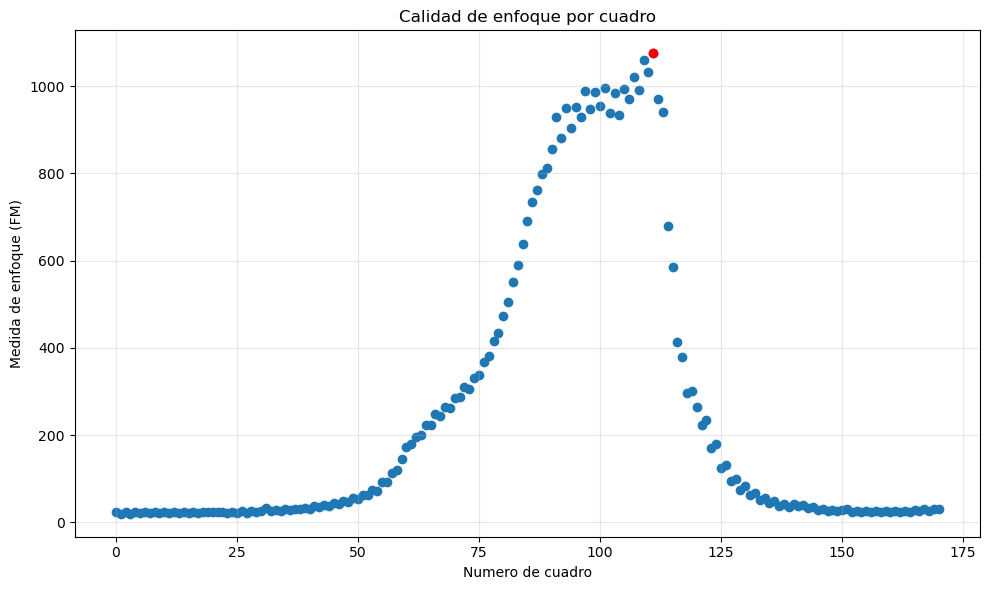

Maximo y cuadro correspondiente: [1074.9931640625, 111]


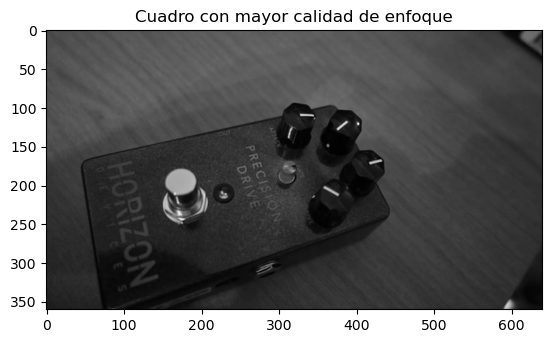

In [23]:
analyzer = CalidadEnfoqueLaplaciano()
fm_por_cuadro = analyzer.calidad(frames_gray)
print(f"Forma del array FM: {fm_por_cuadro.shape}")

maximo = analyzer.grafico(fm_por_cuadro)
print("Maximo y cuadro correspondiente:", maximo)
plt.imshow(frames_gray[maximo[1]], cmap="gray")
plt.title("Cuadro con mayor calidad de enfoque")
plt.show()

Forma del array FM (reticula): (171,)


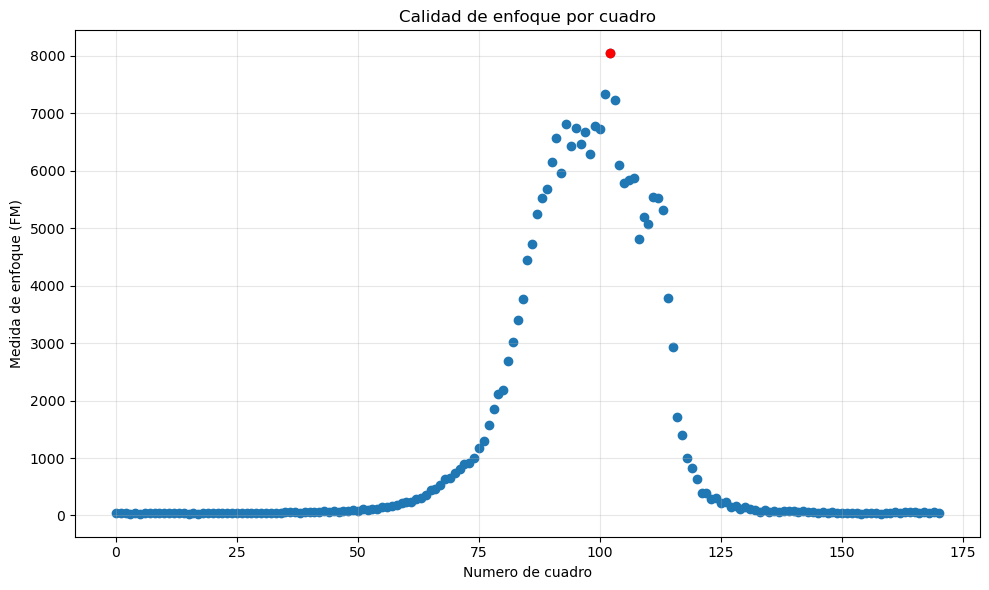

Maximo y cuadro (reticula): [8040.30712890625, 102]


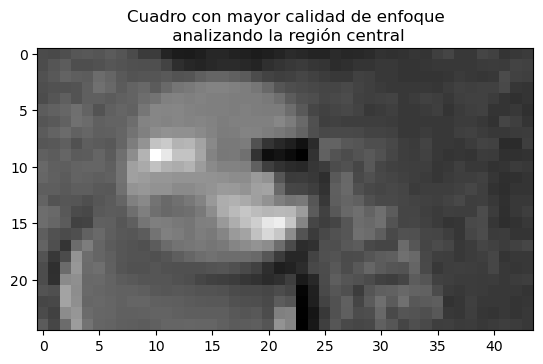

In [21]:
analyzer_recorte = CalidadEnfoqueLaplaciano() 
fm_reticula = analyzer_recorte.calidad(recortes)
print(f"Forma del array FM (reticula): {fm_reticula.shape}")
maximo_reticula = analyzer_recorte.grafico(fm_reticula)
print("Maximo y cuadro (reticula):", maximo_reticula)

plt.imshow(recortes[maximo[1]], cmap="gray")
plt.title("Cuadro con mayor calidad de enfoque\n analizando la región central")
plt.show()

Forma del array FM: (171,)


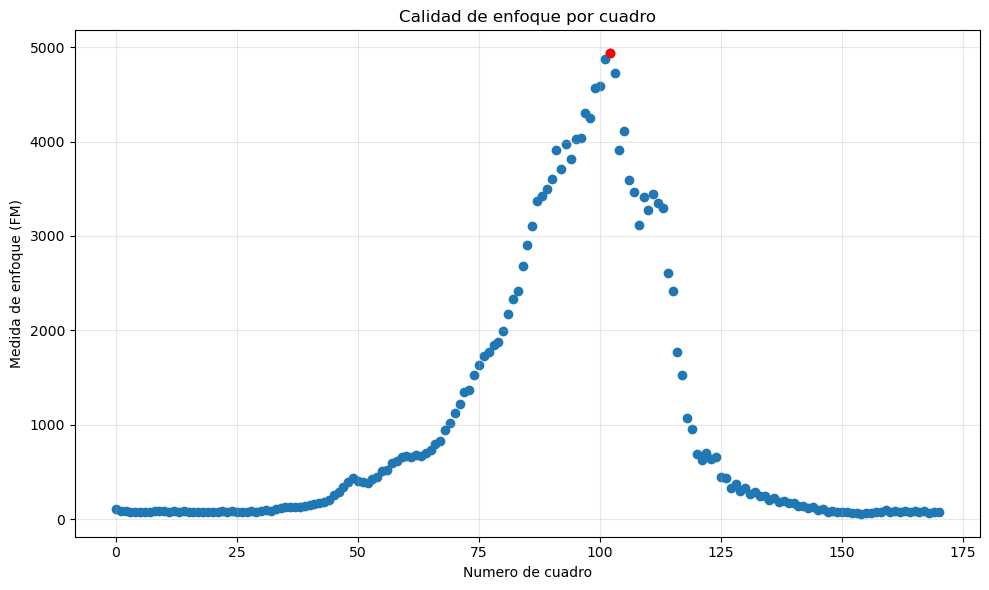

Máximo coeficiente de enfoque promedio:4933.932381735907 y cuadro correspondiente: 102


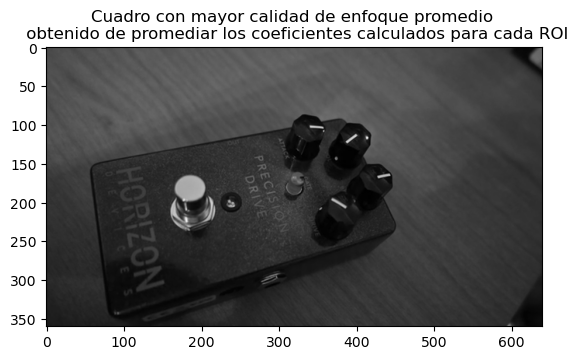

In [25]:
regiones, boxes,lado,coverage=extraer_regiones_de_frames(frames_gray)

analyzer = CalidadEnfoqueLaplaciano() 
fm_por_cuadro = analyzer.calidad(regiones)
print(f"Forma del array FM: {fm_por_cuadro.shape}")

maximo = analyzer.grafico(fm_por_cuadro)
print(f'Máximo coeficiente de enfoque promedio:{maximo[0]} y cuadro correspondiente: {maximo[1]}')

img_vis = cv2.cvtColor(frames_gray[maximo[1],...], cv2.COLOR_GRAY2BGR)
plt.imshow(img_vis)
plt.title('Cuadro con mayor calidad de enfoque promedio \n obtenido de promediar los coeficientes calculados para cada ROI')
plt.show()

Forma del array FM: (171,)


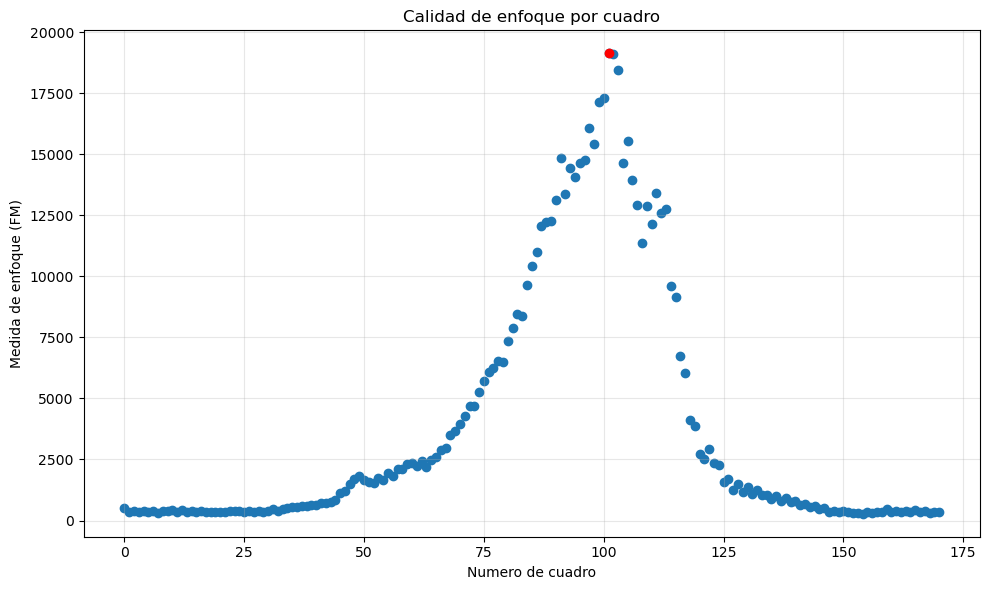

Máximo coeficiente de enfoque promedio:19130.885226779516 y cuadro correspondiente: 101


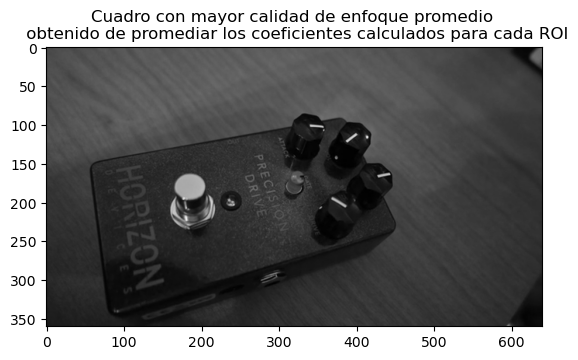

In [25]:
regiones, boxes,lado,coverage=extraer_regiones_de_frames(frames_gray)
analyzer = CalidadEnfoqueLaplaciano() 
fm_por_cuadro = analyzer.calidad(regiones,True)
print(f"Forma del array FM: {fm_por_cuadro.shape}")

maximo = analyzer.grafico(fm_por_cuadro)
print(f'Máximo coeficiente de enfoque promedio:{maximo[0]} y cuadro correspondiente: {maximo[1]}')

img_vis = cv2.cvtColor(frames_gray[maximo[1],...], cv2.COLOR_GRAY2BGR)
plt.imshow(img_vis)
plt.title('Cuadro con mayor calidad de enfoque promedio \n obtenido de promediar los coeficientes calculados para cada ROI')
plt.show()

La métrica laplaciana muestra menor variabilidad que FM al identificar el cuadro de mejor enfoque, tanto cuando se evalúa el cuadro completo (111) como una región central (102) o la matriz de enfoque (101). En contraste con FM, la calidad de enfoque laplaciano presenta mayor sensibilidad, generando curvas con picos más agudos.

Al aplicar *unsharp mask*, la calidad de enfoque laplaciana aumenta en todos los cuadros y el pico se vuelve aún más pronunciado, lo que difiere del comportamiento observado con FM. Esta evidencia sugiere que la métrica laplaciana posee mayor sensibilidad que la métrica FM.
